In [243]:
import cv2 as cv

import numpy as np

import matplotlib.pyplot as plt



# Function to display images using matplotlib

def display_image(image, title='original', colored=None):

    plt.figure(figsize=(10, 10))

    if colored:

        plt.imshow(image[:,:,::-1]) # converting from BGR to RGB

    else:

        plt.imshow(image, cmap='gray')

    plt.axis("off")

    plt.title(title)

    plt.show()


In [244]:
def detect_shape(contour):

    peri = cv.arcLength(contour, True)

    approx = cv.approxPolyDP(contour, 0.02 * peri, True)

    

    if len(approx) == 3:

        return "triangle"

    elif len(approx) == 4:

        return "sq"

    else:

        area = cv.contourArea(contour)

        if peri == 0:

            return "unknown"

        circularity = 4 * np.pi * (area / (peri ** 2))

        if circularity > 0.8:

            return "circle"

        else:

            return "unknown"
        

def boxes_overlap(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check for overlap
    if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
        return True
    return False

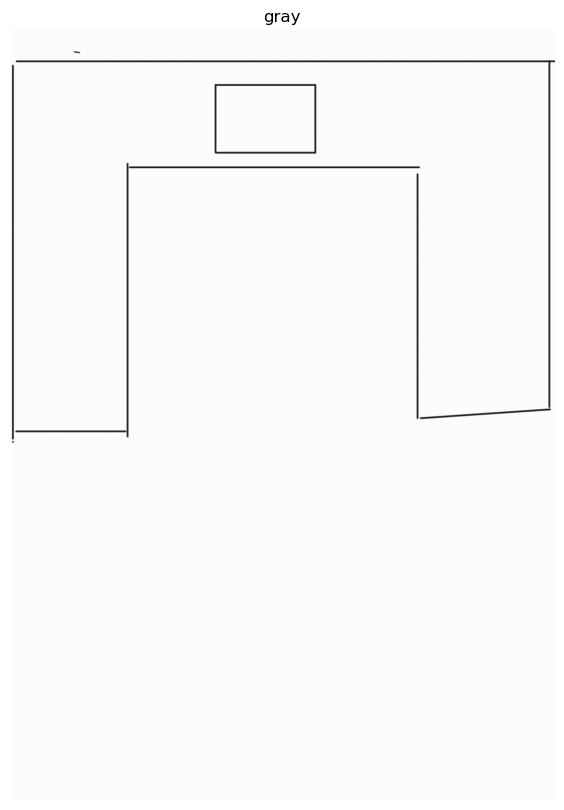

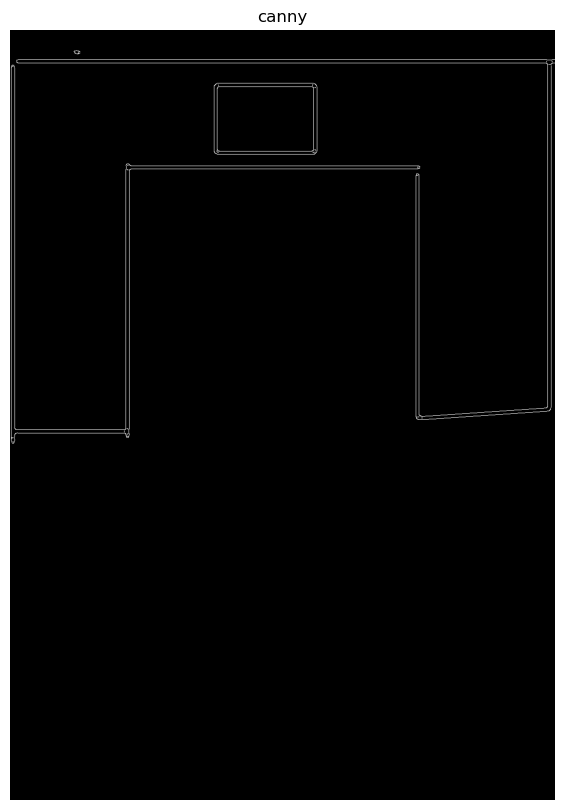

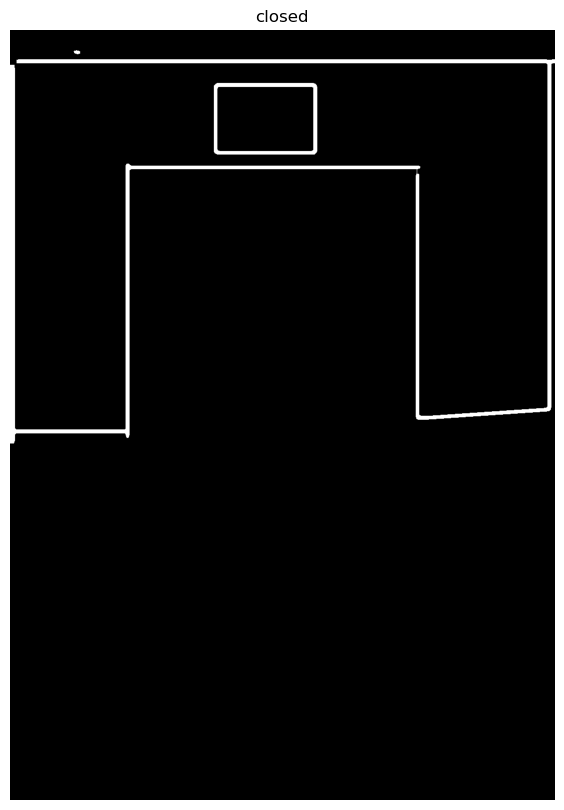

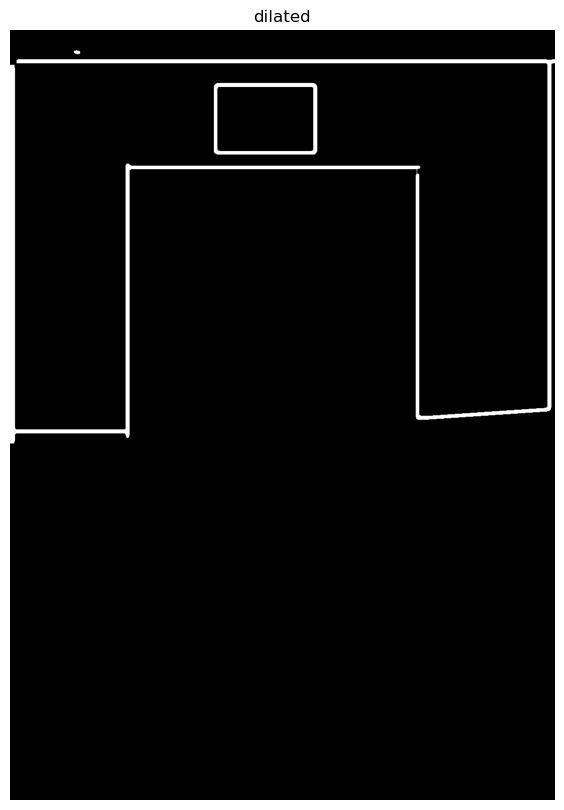

In [245]:
img_path = "imgs/sq2.jpeg"

img = cv.imread(img_path)

img_copy = img.copy()



# Convert to grayscale

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

display_image(gray, "gray")



# Apply Gaussian Blur

gaussian = cv.GaussianBlur(gray, (9, 9), 0)



# Apply Median Blur

median = cv.medianBlur(gaussian, 9)



# Apply Canny Edge Detection

canny = cv.Canny(median, 50, 150)

display_image(canny, "canny")



# Apply Morphological Closing

kernel = np.ones((9, 9), np.uint8)  

closed = cv.morphologyEx(canny, cv.MORPH_CLOSE, kernel)

display_image(closed, "closed")



# Dilate

kernel = np.ones((1, 1), np.uint8)

dilated = cv.dilate(closed, kernel, iterations=1)

display_image(dilated, "dilated")




Number of contours 1


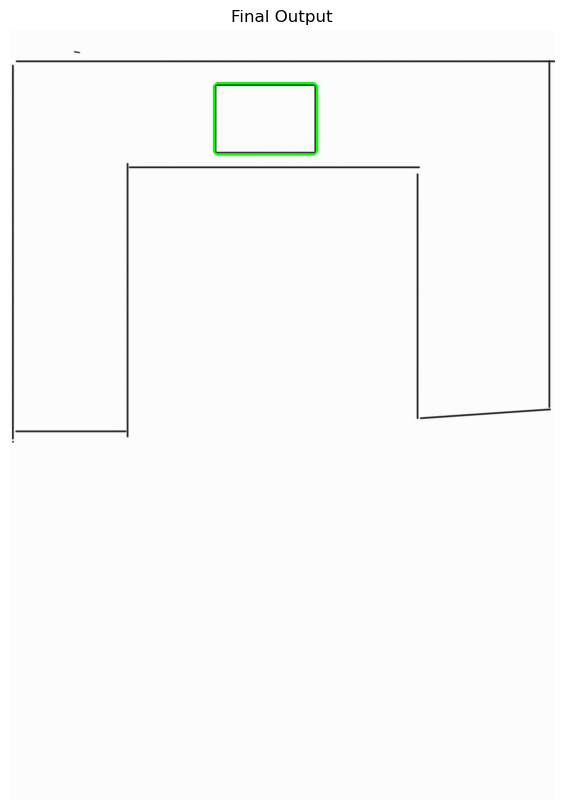

In [246]:
contours, hierarchy = cv.findContours(dilated, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)



# Filter contours based on area and shape

filtered_contours = []

min_area = 100

detected_boxes = []

for contour in contours:

    area = cv.contourArea(contour)

    if area > min_area:

        shape = detect_shape(contour)

        if shape in ["triangle", "sq", "circle"]:

            bounding_box = cv.boundingRect(contour)
            
            # Check for overlap with already detected contours
            is_duplicate = False
            for detected_box in detected_boxes:
                if boxes_overlap(bounding_box, detected_box):
                    is_duplicate = True
                    break

            # If no overlap, consider it as a new object
            if not is_duplicate:
                filtered_contours.append(contour)
                detected_boxes.append(bounding_box)



# Draw and display filtered contours on the original image

for contour in filtered_contours:

    shape = detect_shape(contour)

    #blank_img = np.zeros(img.shape[:2], np.uint8)

    #cv.drawContours(blank_img, [contour], -1, 255, thickness=cv.FILLED)

    #display_image(blank_img, f"Contour: {shape}")

    

    if shape == "triangle":

        color = (0, 0, 255)  # Red for triangle

    elif shape == "sq":

        color = (0, 255, 0)  # Green for square

    elif shape == "circle":

        color = (255, 0, 0)  # Blue for circle

    else:

        color = (200, 200, 200)



    cv.drawContours(img_copy, [contour], -1, color, 3)



# Display final output
print(f"Number of contours {len(filtered_contours)}")
display_image(img_copy, "Final Output", colored=True)
